In [1]:
import pandas as pd
import numpy as np
import re
import json
from pathlib import Path

pd.set_option('display.max_columns', 50)


In [17]:
df_raw = pd.read_csv("listings.csv.gz", compression='gzip', low_memory=False)

In [18]:
df_raw['host_location'].value_counts()

host_location
San Francisco, CA    4465
New York, NY          214
Princeville, HI        87
Calgary, Canada        85
Los Angeles, CA        83
                     ... 
Union City, CA          1
Oakville, Canada        1
Manor, TX               1
Lahaina, HI             1
Dublin, CA              1
Name: count, Length: 227, dtype: int64

In [19]:
df_raw.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [20]:
df_raw.columns
also_needed = ['id', 'last_scraped', 'calendar_last_scraped','first_review', 'number_of_reviews']

covs_v1 = ['instant_bookable','neighbourhood_cleansed', 'calculated_host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'amenities', 'bathrooms']

variable_of_interest = ['review_scores_rating']

COLS = also_needed + covs_v1 + variable_of_interest

In [21]:
# Select columns for analysis
df = df_raw[COLS].copy()
print(f"Selected {len(COLS)} columns")
df.info()


Selected 18 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7780 entries, 0 to 7779
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              7780 non-null   int64  
 1   last_scraped                    7780 non-null   object 
 2   calendar_last_scraped           7780 non-null   object 
 3   first_review                    5910 non-null   object 
 4   number_of_reviews               7780 non-null   int64  
 5   instant_bookable                7780 non-null   object 
 6   neighbourhood_cleansed          7780 non-null   object 
 7   calculated_host_listings_count  7780 non-null   int64  
 8   latitude                        7780 non-null   float64
 9   longitude                       7780 non-null   float64
 10  property_type                   7780 non-null   object 
 11  room_type                       7780 non-null   object 
 12  accommodates  

In [22]:
#Clean instant_bookable
def clean_instant_bookable(x):
    if pd.isna(x):
        return np.nan
    return 1 if x == 't' else 0

df['instant_bookable'] = df['instant_bookable'].apply(clean_instant_bookable)
# Rename to treatment
df.rename(columns={'instant_bookable': 'treatment'}, inplace=True)

df['treatment'].value_counts()


treatment
0    5419
1    2361
Name: count, dtype: int64

In [23]:
# Count amenities from JSON list
def count_amenities(x):
    if pd.isna(x):
        return 0
    try:
        return len(json.loads(x))
    except:
        return len(str(x).split(','))

df['amenities_count'] = df['amenities'].apply(count_amenities)
print("Amenities count stats:")
print(df['amenities_count'].describe())


Amenities count stats:
count    7780.000000
mean       34.111825
std        15.320280
min         0.000000
25%        22.000000
50%        34.000000
75%        45.000000
max        91.000000
Name: amenities_count, dtype: float64


In [24]:
# Compute listing age in months
df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')

df['calendar_last_scraped'] = pd.to_datetime(df['calendar_last_scraped'], errors='coerce')

print(365.25 / 12)

df['listing_age_months'] = ((df['calendar_last_scraped'] - df['first_review']).dt.days / 30.44).round(1)

df.loc[df['listing_age_months'] < 0, 'listing_age_months'] = np.nan

print("Listing age (months) stats:")
print(df['listing_age_months'].describe())


30.4375
Listing age (months) stats:
count    5910.000000
mean       56.931607
std        43.889346
min         0.100000
25%        20.300000
50%        44.300000
75%        88.475000
max       196.000000
Name: listing_age_months, dtype: float64


In [27]:
# Check missing values

analysis_vars = ['treatment','review_scores_rating','neighbourhood_cleansed', 'calculated_host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms','amenities_count', 'listing_age_months']


print("Missing values:")
for col in analysis_vars:
    n_miss = df[col].isna().sum()
    pct = 100 * n_miss / len(df)
    print(f"  {col}: {n_miss} ({pct:.1f}%)")


Missing values:
  treatment: 0 (0.0%)
  review_scores_rating: 1870 (24.0%)
  neighbourhood_cleansed: 0 (0.0%)
  calculated_host_listings_count: 0 (0.0%)
  latitude: 0 (0.0%)
  longitude: 0 (0.0%)
  property_type: 0 (0.0%)
  room_type: 0 (0.0%)
  accommodates: 0 (0.0%)
  bedrooms: 489 (6.3%)
  beds: 1958 (25.2%)
  bathrooms: 1934 (24.9%)
  amenities_count: 0 (0.0%)
  listing_age_months: 1870 (24.0%)


In [28]:
# Complete case analysis. Drop na values
print(f"Rows before: {len(df)}")

df_clean = df.dropna(subset=analysis_vars).copy()
print(f"Rows after complete case: {len(df_clean)}")

# Create final dataset
df_final = df_clean[['id'] + analysis_vars + ['number_of_reviews']].copy()

df_final = df_final.rename(columns={
    'neighbourhood_cleansed': 'neighbourhood',
    'review_scores_rating': 'rating'
})
df_final.head()


Rows before: 7780
Rows after complete case: 4648


,id,treatment,rating,neighbourhood,calculated_host_listings_count,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,bathrooms,amenities_count,listing_age_months,number_of_reviews
0,958,0,4.89,Western Addition,1,37.77028,-122.43317,Entire serviced apartment,Entire home/apt,3,1.0,2.0,1.0,53,193.3,496
1,5858,0,4.87,Bernal Heights,1,37.74474,-122.42089,Entire rental unit,Entire home/apt,4,2.0,2.0,2.0,17,196.0,105
2,8014,0,4.77,Outer Mission,3,37.73077,-122.44827,Private room in home,Private room,1,1.0,1.0,2.0,31,156.9,90
3,8142,0,4.70,Haight Ashbury,20,37.76555,-122.45213,Private room in rental unit,Private room,1,3.0,1.0,4.0,21,131.8,10
4,8339,0,4.86,Western Addition,1,37.77377,-122.43614,Entire condo,Entire home/apt,2,1.0,1.0,1.5,38,184.6,25


In [29]:
# Summary statistics
print(f"\nTotal listings: {len(df_final)}")
print(f"Treated (Instant Book=1): {df_final['treatment'].sum()} ({100*df_final['treatment'].mean():.1f}%)")
print(f"Control (Instant Book=0): {len(df_final) - df_final['treatment'].sum()} ({100*(1-df_final['treatment'].mean()):.1f}%)")
print(f"\nRating mean: {df_final['rating'].mean():.2f}, std: {df_final['rating'].std():.2f}")
print(f"Neighbourhoods: {df_final['neighbourhood'].nunique()}")
print(f"Room types: {df_final['room_type'].unique().tolist()}")



Total listings: 4648
Treated (Instant Book=1): 1176 (25.3%)
Control (Instant Book=0): 3472 (74.7%)

Rating mean: 4.80, std: 0.36
Neighbourhoods: 36
Room types: ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']


In [30]:
df_final

,id,treatment,rating,neighbourhood,calculated_host_listings_count,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,bathrooms,amenities_count,listing_age_months,number_of_reviews
0,958,0,4.89,Western Addition,1,37.770280,-122.433170,Entire serviced apartment,Entire home/apt,3,1.0,2.0,1.0,53,193.3,496
1,5858,0,4.87,Bernal Heights,1,37.744740,-122.420890,Entire rental unit,Entire home/apt,4,2.0,2.0,2.0,17,196.0,105
2,8014,0,4.77,Outer Mission,3,37.730770,-122.448270,Private room in home,Private room,1,1.0,1.0,2.0,31,156.9,90
3,8142,0,4.70,Haight Ashbury,20,37.765550,-122.452130,Private room in rental unit,Private room,1,3.0,1.0,4.0,21,131.8,10
4,8339,0,4.86,Western Addition,1,37.773770,-122.436140,Entire condo,Entire home/apt,2,1.0,1.0,1.5,38,184.6,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,1476930786069111081,0,5.00,Castro/Upper Market,1,37.765740,-122.427290,Entire guesthouse,Entire home/apt,2,1.0,1.0,1.0,61,0.6,4
7705,1479759636995852528,1,5.00,Inner Sunset,2,37.761490,-122.465160,Entire home,Entire home/apt,1,1.0,1.0,1.0,24,0.8,2
7708,1480842129090484233,1,5.00,Outer Sunset,1,37.756120,-122.506870,Entire home,Entire home/apt,2,1.0,1.0,1.0,29,0.3,2
7723,1483591401661662403,0,1.00,Downtown/Civic Center,9,37.786898,-122.411684,Room in hotel,Private room,2,1.0,1.0,1.0,15,0.6,1


In [31]:
df_final.columns

Index(['id', 'treatment', 'rating', 'neighbourhood',
       'calculated_host_listings_count', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'bathrooms', 'amenities_count', 'listing_age_months',
       'number_of_reviews'],
      dtype='object')

In [32]:
import numpy as np, pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample

In [33]:
# --------- 1) Set up design ----------
df = df_final.copy().dropna(subset=["treatment","rating"])
y = df["rating"].astype(float).values
T = df["treatment"].astype(int).values

cat_cols = ["neighbourhood","property_type","room_type"]
num_cols = ["calculated_host_listings_count","latitude","longitude",
            "accommodates","bedrooms","bathrooms","amenities_count","listing_age_months"]

# Shared preprocessor (one-hot for cats; pass-through nums)
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
    ("num", "passthrough", num_cols)
])

# Models
ps_model = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=200, solver="lbfgs"))
])

y_model = Pipeline([
    ("pre", pre),
    ("rf", RandomForestRegressor(n_estimators=400, min_samples_leaf=5, n_jobs=-1, random_state=42))
])

# --------- 2) Cross-fitting to get out-of-fold e(x), m0(x), m1(x) ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
e_hat = np.zeros(len(df))
m0_hat = np.zeros(len(df))
m1_hat = np.zeros(len(df))

for tr_idx, te_idx in kf.split(df):
    # propensity
    ps_model.fit(df.iloc[tr_idx][cat_cols+num_cols], T[tr_idx])
    e_hat[te_idx] = ps_model.predict_proba(df.iloc[te_idx][cat_cols+num_cols])[:,1].clip(1e-6, 1-1e-6)

    # outcome models on train split
    X_tr = df.iloc[tr_idx][cat_cols+num_cols]
    y_tr = y[tr_idx]; T_tr = T[tr_idx]
    # m1: train on treated
    y_model.fit(X_tr[T_tr==1], y_tr[T_tr==1])
    m1_hat[te_idx] = y_model.predict(df.iloc[te_idx][cat_cols+num_cols])
    # m0: train on control
    y_model.fit(X_tr[T_tr==0], y_tr[T_tr==0])
    m0_hat[te_idx] = y_model.predict(df.iloc[te_idx][cat_cols+num_cols])

# --------- 3) Trim, then AIPW point estimate ----------
trim_lo, trim_hi = 0.05, 0.95
keep = (e_hat >= trim_lo) & (e_hat <= trim_hi)
Y, TT = y[keep], T[keep]
e, m0, m1 = e_hat[keep], m0_hat[keep], m1_hat[keep]

aipw_scores = (TT*(Y-m1)/e) - ((1-TT)*(Y-m0)/(1-e)) + (m1-m0)
tau_hat = aipw_scores.mean()
print(f"AIPW ATE (trim {trim_lo}-{trim_hi}): {tau_hat:.4f}")

# --------- 4) (Optional) balance & weight diagnostics ----------
def smd_weighted(x, t, w):
    # works for numeric x; for categoricals, compute on dummies
    m1 = np.average(x[t==1], weights=w[t==1])
    m0 = np.average(x[t==0], weights=w[t==0])
    v1 = np.average((x[t==1]-m1)**2, weights=w[t==1])
    v0 = np.average((x[t==0]-m0)**2, weights=w[t==0])
    sp = np.sqrt(0.5*(v1+v0) + 1e-12)
    return (m1-m0)/sp

# stabilized IPTW for quick SMDs (design check)
p_t = TT.mean()
w = np.where(TT==1, p_t/e, (1-p_t)/(1-e))

ess = (w.sum()**2) / (w**2).sum()
print(f"Effective sample size (IPTW): {ess:.1f}")

# Example SMD on a numeric covariate (listing age)
smd_age = smd_weighted(df.loc[keep,"listing_age_months"].astype(float).values, TT, w)
print(f"SMD listing_age_months (weighted): {smd_age:.3f}")

# --------- 5) Bootstrap CI (cluster by neighbourhood if you want) ----------
def aipw_from_index(idx):
    Yi, Ti = y[idx], T[idx]
    Xi = df.iloc[idx]
    # re-fit within bootstrap sample with 3-fold cross-fitting for speed
    kf2 = KFold(n_splits=3, shuffle=True)
    e_b = np.zeros(len(idx)); m0_b = np.zeros(len(idx)); m1_b = np.zeros(len(idx))
    for tr, te in kf2.split(Xi):
        ps_model.fit(Xi.iloc[tr][cat_cols+num_cols], Ti[tr])
        e_b[te] = ps_model.predict_proba(Xi.iloc[te][cat_cols+num_cols])[:,1].clip(1e-6,1-1e-6)
        # m1
        y_model.fit(Xi.iloc[tr][cat_cols+num_cols][Ti[tr]==1], Yi[tr][Ti[tr]==1])
        m1_b[te] = y_model.predict(Xi.iloc[te][cat_cols+num_cols])
        # m0
        y_model.fit(Xi.iloc[tr][cat_cols+num_cols][Ti[tr]==0], Yi[tr][Ti[tr]==0])
        m0_b[te] = y_model.predict(Xi.iloc[te][cat_cols+num_cols])
    mask = (e_b>=trim_lo)&(e_b<=trim_hi)
    sc = (Ti[mask]*(Yi[mask]-m1_b[mask])/e_b[mask]
          - (1-Ti[mask])*(Yi[mask]-m0_b[mask])/(1-e_b[mask])
          + (m1_b[mask]-m0_b[mask]))
    return sc.mean()

# plain bootstrap
B = 300
boot = np.array([aipw_from_index(np.random.choice(len(df), size=len(df), replace=True)) for _ in range(B)])
se = boot.std(ddof=1)
ci = (tau_hat - 1.96*se, tau_hat + 1.96*se)
print(f"Bootstrap SE: {se:.4f}   95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

AIPW ATE (trim 0.05-0.95): -0.0334
Effective sample size (IPTW): 3531.1
SMD listing_age_months (weighted): -0.007


/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Bootstrap SE: 0.0122   95% CI: [-0.0574, -0.0095]


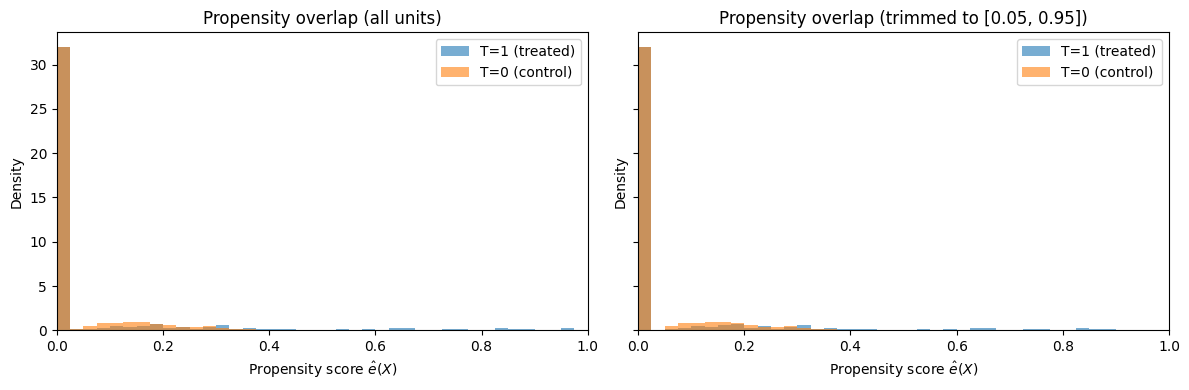

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Histograms of \hat e(X) by treatment: all units vs trimmed ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ax, mask, title in [
    (axes[0], np.ones_like(e_hat, dtype=bool), "Propensity overlap (all units)"),
    (axes[1], keep, f"Propensity overlap (trimmed to [{trim_lo:.2f}, {trim_hi:.2f}])"),
]:
    ax.hist(e_hat[mask & (T==1)], bins=40, range=(0,1), density=True, alpha=0.6, label="T=1 (treated)")
    ax.hist(e_hat[mask & (T==0)], bins=40, range=(0,1), density=True, alpha=0.6, label="T=0 (control)")
    ax.set_xlim(0, 1)
    ax.set_xlabel("Propensity score $\hat e(X)$")
    ax.set_ylabel("Density")
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

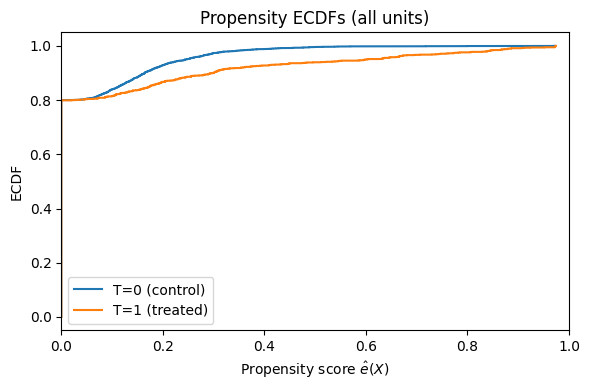

In [57]:
def ecdf(x):
    x = np.sort(x)
    y = np.linspace(0, 1, len(x), endpoint=True)
    return x, y

fig, ax = plt.subplots(figsize=(6,4))
x1,y1 = ecdf(e_hat[T==1])
x0,y0 = ecdf(e_hat[T==0])
ax.step(x0,y0, where="post", label="T=0 (control)")
ax.step(x1,y1, where="post", label="T=1 (treated)")
ax.set_xlim(0,1)
ax.set_xlabel("Propensity score $\hat e(X)$")
ax.set_ylabel("ECDF")
ax.set_title("Propensity ECDFs (all units)")
ax.legend()
plt.tight_layout(); plt.show()

In [35]:
import numpy as np

def aipw_with_trim(e_hat, m0_hat, m1_hat, y, t, trim_lo=0.05, trim_hi=0.95):
    keep = (e_hat >= trim_lo) & (e_hat <= trim_hi)
    Y, T, e, m0, m1 = y[keep], t[keep], e_hat[keep], m0_hat[keep], m1_hat[keep]
    sc = (T*(Y - m1)/e) - ((1 - T)*(Y - m0)/(1 - e)) + (m1 - m0)  # AIPW influence scores
    return sc.mean(), keep.sum()

for lo, hi in [(0.01,0.99), (0.05,0.95), (0.10,0.90), (0.15,0.85)]:
    tau, nkeep = aipw_with_trim(e_hat, m0_hat, m1_hat, y, T, lo, hi)
    print(f"trim[{lo:.2f},{hi:.2f}]  AIPW={tau:.4f}   n={nkeep}")

trim[0.01,0.99]  AIPW=0.0019   n=4645
trim[0.05,0.95]  AIPW=-0.0334   n=4490
trim[0.10,0.90]  AIPW=-0.0345   n=3866
trim[0.15,0.85]  AIPW=-0.0476   n=2896


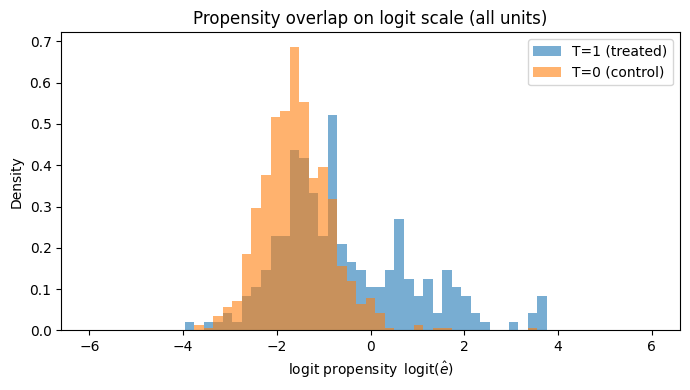

In [58]:
# logit transform with clipping to avoid infs
eps = 1e-6
logit = lambda p: np.log(np.clip(p,eps,1-eps)/(1-np.clip(p,eps,1-eps)))

fig, ax = plt.subplots(figsize=(7,4))
bins = np.linspace(-6, 6, 60)  # common bins on logit scale
ax.hist(logit(e_hat[T==1]), bins=bins, density=True, alpha=0.6, label="T=1 (treated)")
ax.hist(logit(e_hat[T==0]), bins=bins, density=True, alpha=0.6, label="T=0 (control)")
ax.set_xlabel("logit propensity $\\,\\mathrm{logit}(\\hat e)$")
ax.set_ylabel("Density")
ax.set_title("Propensity overlap on logit scale (all units)")
ax.legend()
plt.tight_layout(); plt.show()

In [54]:
# Rosenbaum sensitivity for 1:1 PS-matched pairs (Wilcoxon signed-rank)
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from math import erf, sqrt

# --- matching on logit propensity with caliper (safe for 0/1/NaN) ---
def _make_pairs_safe(e_hat, T, caliper_mult=0.2, replace=False):
    e = np.clip(np.asarray(e_hat, float), 1e-6, 1-1e-6)
    logit = np.log(e/(1-e))
    mask = np.isfinite(logit) & np.isfinite(T)
    logit, Tm = logit[mask], np.asarray(T, int)[mask]
    idx_all = np.where(mask)[0]

    idx_t = np.where(Tm==1)[0]
    idx_c = np.where(Tm==0)[0]
    if len(idx_t)==0 or len(idx_c)==0:
        raise ValueError("No treated or control units after masking.")

    caliper = caliper_mult * np.std(logit)
    nn = NearestNeighbors(n_neighbors=1).fit(logit[idx_c].reshape(-1,1))
    dist, nbr = nn.kneighbors(logit[idx_t].reshape(-1,1))

    pairs, used_c = [], set()
    for k, it in enumerate(idx_t):
        jc = idx_c[nbr[k,0]]
        if dist[k,0] <= caliper and (replace or jc not in used_c):
            pairs.append((idx_all[it], idx_all[jc]))
            used_c.add(jc)
    return pairs

# --- rank components for Wilcoxon signed-rank ---
def _signed_rank_components(diffs):
    diffs = diffs[np.isfinite(diffs)]
    diffs = diffs[diffs != 0]
    if diffs.size == 0:
        raise ValueError("All pair differences are zero.")
    q = pd.Series(np.abs(diffs)).rank(method="average").to_numpy()  # midranks
    W_plus = q[diffs > 0].sum()  # sum of ranks with positive sign
    return q, W_plus

# --- Rosenbaum upper-tail p-value under Gamma (normal approx) ---
def _upper_p_rosenbaum(q, W_plus, gamma):
    p = gamma/(1.0 + gamma)
    mu = p * q.sum()
    var = p * (1-p) * np.sum(q**2)
    sd = np.sqrt(max(var, 1e-12))
    z = (W_plus - mu - 0.5) / sd  # continuity correction
    p_upper = 0.5 * (1 - erf(z / sqrt(2)))  # Pr(Z >= z)
    return float(p_upper), float(mu), float(sd)

def rosenbaum_sensitivity(y, T, e_hat, caliper_mult=0.2, gammas=None, replace=False, alt="less"):
    """
    Rosenbaum bounds with 1:1 matching.
    alt='less'  : test H1(treatment DECREASES outcome)  ← typical for your negative ATE
    alt='greater': test H1(treatment INCREASES outcome)
    """
    if gammas is None:
        gammas = np.round(np.concatenate([[1.0], np.arange(1.05, 2.51, 0.05)]), 2)

    pairs = _make_pairs_safe(e_hat, T, caliper_mult=caliper_mult, replace=replace)
    if len(pairs) < 30:
        print(f"Warning: only {len(pairs)} matched pairs — results may be noisy.")

    y = np.asarray(y, float)
    diffs = y[[i for i,_ in pairs]] - y[[j for _,j in pairs]]
    # for a NEGATIVE effect, flip diffs so "harm" is positive and we can use upper-tail
    if alt == "less":
        diffs = -diffs

    q, W_plus = _signed_rank_components(diffs)

    rows = []
    for g in gammas:
        pU, mu, sd = _upper_p_rosenbaum(q, W_plus, g)
        rows.append({"Gamma": g, "W_plus": W_plus, "mu_G": mu, "sd_G": sd, "p_value": pU})
    out = pd.DataFrame(rows)

    # critical Gamma where the (upper-bound) p-value first exceeds 0.05
    crit = out.loc[out.p_value.gt(0.05), "Gamma"]
    gamma_star = float(crit.iloc[0]) if not crit.empty else np.inf
    return out, gamma_star, len(pairs)


In [55]:
tbl, gamma_star, n_pairs = rosenbaum_sensitivity(
    y.astype(float),          # outcome (rating)
    T.astype(int),            # treatment 0/1
    e_hat,                    # propensity scores
    caliper_mult=0.2,         # try 0.2–0.3
    alt="less"                # H1: treatment decreases outcome
)

print(f"Matched pairs: {n_pairs}")
print(tbl.head())
print(f"Critical Γ for negative effect (p>0.05): {gamma_star}")


Matched pairs: 149
   Gamma  W_plus         mu_G        sd_G   p_value
0   1.00  5454.0  4658.000000  460.317961  0.041980
1   1.05  5454.0  4771.609756  460.181022  0.069198
2   1.10  5454.0  4879.809524  459.795762  0.106069
3   1.15  5454.0  4982.976744  459.196296  0.152760
4   1.20  5454.0  5081.454545  458.411874  0.208512
Critical Γ for negative effect (p>0.05): 1.05


In [41]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 19.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

cat_cols = ["neighbourhood","property_type","room_type"]
num_cols = ["calculated_host_listings_count","latitude","longitude",
            "accommodates","bedrooms","bathrooms","amenities_count","listing_age_months"]

# build a design matrix that already includes T as a passthrough column
Xk2 = df.loc[mask, cat_cols + num_cols].copy()
Xk2["T"] = Tk  # add treatment to the table we transform

pre_ow = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
     ("num", "passthrough", num_cols),
     ("t",   "passthrough", ["T"])]
)

Xmat = pre_ow.fit_transform(Xk2)   # sparse OK
ols = LinearRegression()
ols.fit(Xmat, Yk, sample_weight=w)

# find the coefficient on T
feat_names = pre_ow.get_feature_names_out().tolist()
t_idx = feat_names.index("t__T")
tau_ow_reg = ols.coef_[t_idx]
print(f"OWATE (overlap-weighted RA): {tau_ow_reg:.4f}")


OWATE (overlap-weighted RA): -0.0581


In [61]:
from sklearn.neighbors import NearestNeighbors

# work on trimmed sample
Yk, Tk, ek = y[keep], T[keep], e_hat[keep]
logit = np.log(ek/(1-ek))

idx_t = np.where(Tk==1)[0]
idx_c = np.where(Tk==0)[0]

# choose caliper ~ 0.2 SD of logit propensity
caliper = 0.2 * np.std(logit)

nn = NearestNeighbors(n_neighbors=1).fit(logit[idx_c].reshape(-1,1))
dist, j = nn.kneighbors(logit[idx_t].reshape(-1,1))
pairs = [(idx_t[i], idx_c[j[i,0]]) for i in range(len(idx_t)) if dist[i,0] <= caliper]

print("Matched pairs:", len(pairs))

# matched ATT (nonparametric)
difs = np.array([Yk[i]-Yk[j] for (i,j) in pairs])
tau_match = difs.mean()
print(f"Matching effect (ATT, calipered): {tau_match:.4f}")

/var/folders/2w/rxvnjs6x2117m8by787lz0cw0000gn/T/ipykernel_43440/2763009315.py:5: RuntimeWarning: divide by zero encountered in log
  logit = np.log(ek/(1-ek))
/Users/jc/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [65]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# --- use the SAME trim as your main AIPW analysis ---
trim_lo, trim_hi = 0.05, 0.95
keep = (e_hat >= trim_lo) & (e_hat <= trim_hi) & np.isfinite(e_hat)

D = df.loc[keep, :]
t = T[keep].astype(int)
e = e_hat[keep].astype(float)

# 1) clip propensities again for safety
e = np.clip(e, 1e-6, 1 - 1e-6)

# 2) stabilized IPTW weights
p_t = t.mean()
w = np.where(t == 1, p_t / e, (1 - p_t) / (1 - e))

# 3) drop rows with non-finite weights
row_ok = np.isfinite(w) & (w > 0)
D, t, e, w = D.loc[row_ok, :], t[row_ok], e[row_ok], w[row_ok]

# Design matrix (dense)
cat_cols = ["neighbourhood","property_type","room_type"]
num_cols = ["calculated_host_listings_count","latitude","longitude",
            "accommodates","bedrooms","bathrooms","amenities_count","listing_age_months"]

pre = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
     ("num", "passthrough", num_cols)],
    remainder="drop"
)
X = pre.fit_transform(D[cat_cols + num_cols])
feat_names = list(pre.named_transformers_["cat"].get_feature_names_out(cat_cols)) + num_cols

# 4) drop columns with no variation in a treatment arm (avoid 0 SD)
vary_ok = []
for j in range(X.shape[1]):
    xj = X[:, j]
    if (np.ptp(xj[t == 1]) > 0) and (np.ptp(xj[t == 0]) > 0):
        vary_ok.append(j)
X = X[:, vary_ok]
feat_names = [feat_names[j] for j in vary_ok]

# SMD function with ridge in denominator
def smd_w(x, t, w=None, eps=1e-8):
    if w is None:
        m1, m0 = x[t==1].mean(), x[t==0].mean()
        v1, v0 = x[t==1].var(ddof=0), x[t==0].var(ddof=0)
    else:
        m1 = np.average(x[t==1], weights=w[t==1])
        m0 = np.average(x[t==0], weights=w[t==0])
        v1 = np.average((x[t==1]-m1)**2, weights=w[t==1])
        v0 = np.average((x[t==0]-m0)**2, weights=w[t==0])
    sp = np.sqrt(0.5*(v1+v0) + eps)
    return (m1 - m0)/sp

smd_before = np.array([smd_w(X[:, j], t, None) for j in range(X.shape[1])])
smd_after  = np.array([smd_w(X[:, j], t, w)   for j in range(X.shape[1])])

tbl = pd.DataFrame({
    "feature": feat_names,
    "SMD_before": smd_before,
    "SMD_after":  smd_after,
    "|SMD|_before": np.abs(smd_before),
    "|SMD|_after":  np.abs(smd_after),
}).sort_values("|SMD|_after", ascending=False)

# Effective sample size (finite weights only)
ess = (w.sum()**2) / (w**2).sum()

print(f"Max |SMD| before: {np.abs(smd_before).max():.3f}   after: {np.abs(smd_after).max():.3f}")
print(f'% |SMD|<0.1 before: {(np.abs(smd_before)<0.1).mean():.1%}   after: {(np.abs(smd_after)<0.1).mean():.1%}')
print(f"Effective sample size (stabilized IPTW): {ess:.1f}")
tbl.head(15)


Max |SMD| before: 0.496   after: 0.215
% |SMD|<0.1 before: 50.0%   after: 81.0%
Effective sample size (stabilized IPTW): 745.3


,feature,SMD_before,SMD_after,|SMD|_before,|SMD|_after
21,neighbourhood_Outer Sunset,-0.146030,-0.215291,0.146030,0.215291
52,longitude,0.132569,0.188841,0.132569,0.188841
6,neighbourhood_Excelsior,-0.233866,-0.164527,0.233866,0.164527
39,property_type_Private room in condo,-0.158627,-0.153005,0.158627,0.153005
43,property_type_Room in aparthotel,0.219507,0.152518,0.219507,0.152518
36,property_type_Entire loft,0.139007,0.135235,0.139007,0.135235
15,neighbourhood_Nob Hill,0.318406,0.127563,0.318406,0.127563
9,neighbourhood_Haight Ashbury,0.001212,0.127278,0.001212,0.127278
50,calculated_host_listings_count,0.380444,0.124028,0.380444,0.124028
37,property_type_Entire rental unit,-0.055448,0.121448,0.055448,0.121448


<Figure size 600x1000 with 0 Axes>

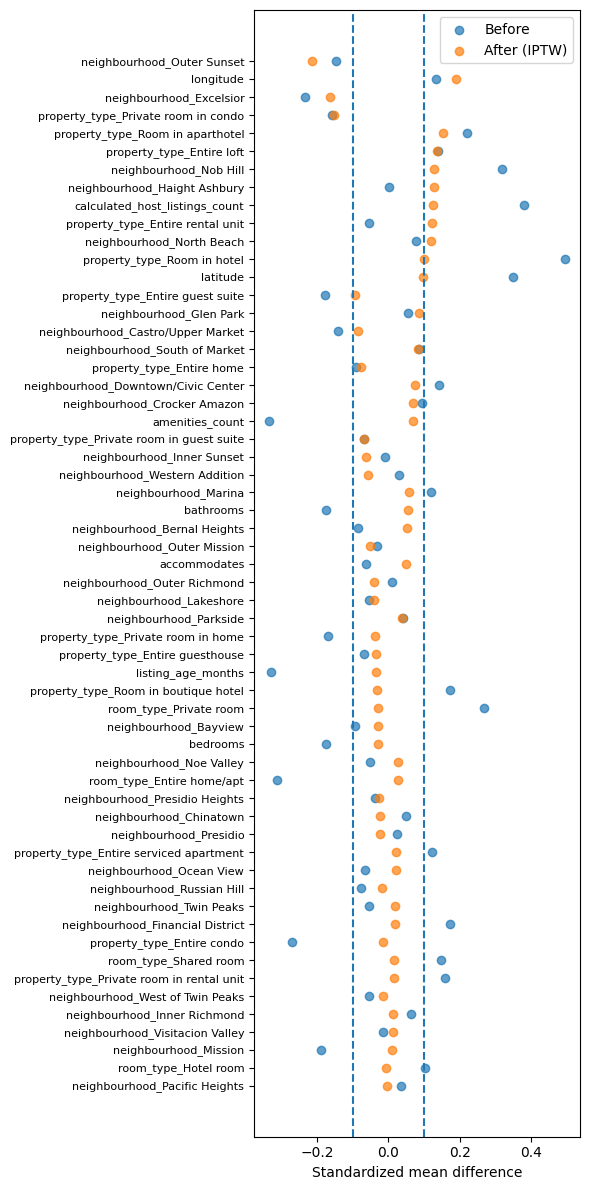

<Figure size 640x480 with 0 Axes>

In [70]:
import matplotlib.pyplot as plt

order = np.argsort(np.abs(smd_after))
ypos = np.arange(len(order))
plt.figure(figsize=(6,10))
plt.figure(figsize=(6, min(12, 0.22*len(order)+2)))
plt.scatter(smd_before[order], ypos, label="Before", alpha=0.7)
plt.scatter(smd_after[order],  ypos, label="After (IPTW)", alpha=0.7)
plt.axvline(0.1,  ls="--"); plt.axvline(-0.1, ls="--")
plt.yticks(ypos, [feat_names[i] for i in order], fontsize=8)
plt.xlabel("Standardized mean difference"); plt.legend(); plt.tight_layout(); plt.show()
plt.savefig("loveplot2.png")  # PNG for reports

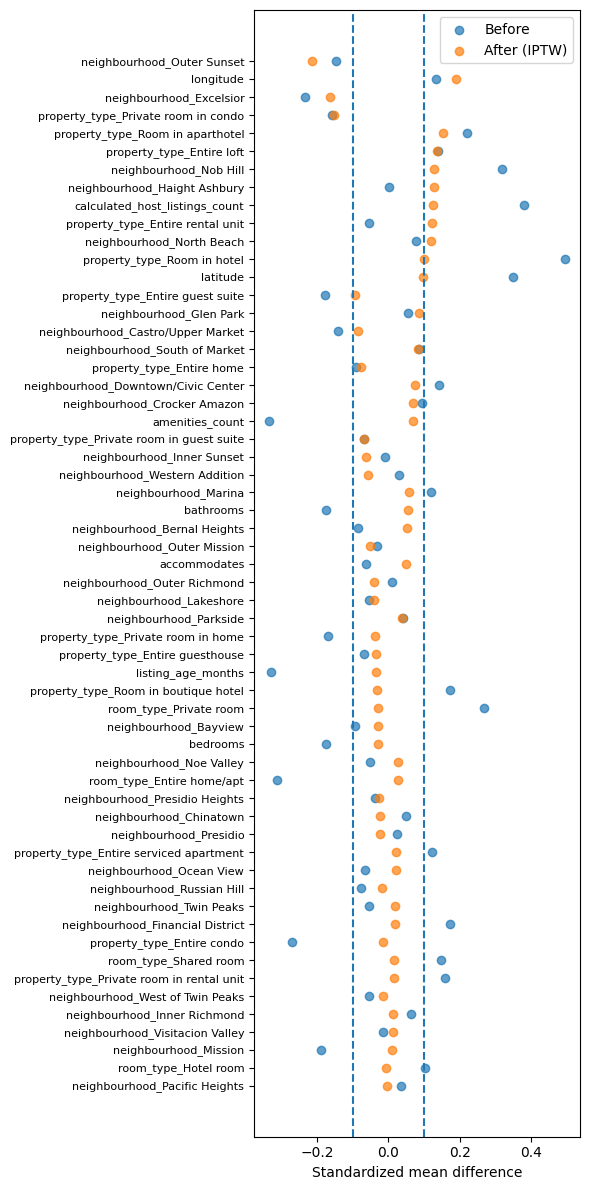

In [71]:
import numpy as np
import matplotlib.pyplot as plt

order = np.argsort(np.abs(smd_after))
ypos  = np.arange(len(order))
fig_h = min(12, 0.22*len(order) + 2)   # dynamic height

fig, ax = plt.subplots(figsize=(6, fig_h))

ax.scatter(smd_before[order], ypos, label="Before", alpha=0.7)
ax.scatter(smd_after[order],  ypos, label="After (IPTW)", alpha=0.7)

ax.axvline(0.10, ls="--"); ax.axvline(-0.10, ls="--")
ax.set_yticks(ypos)
ax.set_yticklabels([feat_names[i] for i in order], fontsize=8)
ax.set_xlabel("Standardized mean difference")
ax.legend()

fig.tight_layout()
fig.savefig("loveplot2.png", dpi=300, bbox_inches="tight")   # save BEFORE show
# Optional vector export:
# fig.savefig("loveplot2.pdf", bbox_inches="tight")

plt.show()
# plt.close(fig)  # optional cleanup


In [72]:
def aipw_bootstrap_ci(df, y, T, cat_cols, num_cols, trim_lo, trim_hi, B=300, seed=42):
    rng = np.random.default_rng(seed)
    def aipw_once(index):
        Xi, Yi, Ti = df.iloc[index], y[index], T[index]
        # cross-fit (reuse your ps_model/y_model definitions)
        kf = KFold(n_splits=3, shuffle=True, random_state=seed)
        e_b = np.zeros(len(index)); m0_b = np.zeros(len(index)); m1_b = np.zeros(len(index))
        for tr, te in kf.split(Xi):
            ps_model.fit(Xi.iloc[tr][cat_cols+num_cols], Ti[tr])
            e_b[te] = ps_model.predict_proba(Xi.iloc[te][cat_cols+num_cols])[:,1].clip(1e-6,1-1e-6)
            # m1
            y_model.fit(Xi.iloc[tr][cat_cols+num_cols][Ti[tr]==1], Yi[tr][Ti[tr]==1])
            m1_b[te] = y_model.predict(Xi.iloc[te][cat_cols+num_cols])
            # m0
            y_model.fit(Xi.iloc[tr][cat_cols+num_cols][Ti[tr]==0], Yi[tr][Ti[tr]==0])
            m0_b[te] = y_model.predict(Xi.iloc[te][cat_cols+num_cols])
        keep = (e_b >= trim_lo) & (e_b <= trim_hi)
        sc = (Ti[keep]*(Yi[keep]-m1_b[keep])/e_b[keep]
              - (1-Ti[keep])*(Yi[keep]-m0_b[keep])/(1-e_b[keep])
              + (m1_b[keep]-m0_b[keep]))
        return sc.mean()

    # point estimate on the full sample at this trim
    # (reuse your previously computed e_hat, m0_hat, m1_hat if they were fit on full data;
    # recompute if you want the point estimate perfectly aligned with the bootstrap routine)
    tau_hat = aipw_once(np.arange(len(df)))

    # bootstrap
    boot = np.array([aipw_once(rng.integers(0, len(df), len(df))) for _ in range(B)])
    se = boot.std(ddof=1)
    ci_norm = (tau_hat - 1.96*se, tau_hat + 1.96*se)
    ci_pct = (np.percentile(boot, 2.5), np.percentile(boot, 97.5))  # optional percentile CI
    return tau_hat, se, ci_norm, ci_pct


In [74]:
import numpy as np

# ---------- Utilities ----------
def aipw_point(y, t, e, m0, m1, lo=0.05, hi=0.95):
    keep = (e >= lo) & (e <= hi)
    if keep.sum() == 0:
        return np.nan
    Y, T, eK, m0K, m1K = y[keep], t[keep], e[keep], m0[keep], m1[keep]
    sc = (T*(Y - m1K)/eK) - ((1-T)*(Y - m0K)/(1-eK)) + (m1K - m0K)
    return sc.mean()

def aipw_bootstrap(df, y, T, cat_cols, num_cols, lo, hi, B=300, seed=42,
                   cluster_col=None):
    rng = np.random.default_rng(seed)

    # we reuse your ps_model and y_model defined above
    def fit_once(index):
        Xi, Yi, Ti = df.iloc[index], y[index], T[index]
        # 3-fold cross-fit inside bootstrap replicate
        kf2 = KFold(n_splits=3, shuffle=True, random_state=seed)
        e_b = np.zeros(len(index)); m0_b = np.zeros(len(index)); m1_b = np.zeros(len(index))
        for tr, te in kf2.split(Xi):
            ps_model.fit(Xi.iloc[tr][cat_cols+num_cols], Ti[tr])
            e_b[te] = ps_model.predict_proba(Xi.iloc[te][cat_cols+num_cols])[:,1].clip(1e-6, 1-1e-6)

            # m1
            y_model.fit(Xi.iloc[tr][cat_cols+num_cols][Ti[tr]==1], Yi[tr][Ti[tr]==1])
            m1_b[te] = y_model.predict(Xi.iloc[te][cat_cols+num_cols])
            # m0
            y_model.fit(Xi.iloc[tr][cat_cols+num_cols][Ti[tr]==0], Yi[tr][Ti[tr]==0])
            m0_b[te] = y_model.predict(Xi.iloc[te][cat_cols+num_cols])

        return aipw_point(Yi, Ti, e_b, m0_b, m1_b, lo, hi)

    # point estimate using your already-computed out-of-fold predictions
    tau_hat = aipw_point(y, T, e_hat, m0_hat, m1_hat, lo, hi)

    # choose resampling indices
    if cluster_col is None:
        def draw_index():
            return rng.integers(0, len(df), size=len(df))
    else:
        # cluster bootstrap: sample clusters with replacement, then take all rows in those clusters
        clusters = df[cluster_col].to_numpy()
        uniq, inv = np.unique(clusters, return_inverse=True)
        groups = [np.where(inv==g)[0] for g in range(len(uniq))]
        def draw_index():
            take = rng.integers(0, len(groups), size=len(groups))
            return np.concatenate([groups[i] for i in take])

    # run bootstrap
    boot = np.empty(B)
    for b in range(B):
        idx = draw_index()
        boot[b] = fit_once(idx)

    se = np.nanstd(boot, ddof=1)
    ci_norm = (tau_hat - 1.96*se, tau_hat + 1.96*se)
    ci_pct  = (np.nanpercentile(boot, 2.5), np.nanpercentile(boot, 97.5))
    return tau_hat, se, ci_norm, ci_pct

# ---------- Run for multiple trims ----------
for lo, hi in [(0.05,0.95), (0.10,0.90), (0.15,0.85)]:
    tau, se, ci_norm, ci_pct = aipw_bootstrap(
        df, y, T, cat_cols, num_cols, lo, hi, B=300, seed=123, cluster_col=None  # set to 'neighbourhood' to cluster
    )
    print(f"Trim [{lo:.2f},{hi:.2f}]  tau={tau:.4f}  SE={se:.4f}  "
          f"95% CI (normal)={ci_norm}  95% CI (percentile)={ci_pct}")


TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

In [76]:
# --------- 1) Set up design ----------
df = df_final.copy().dropna(subset=["treatment","rating"])
y = df["rating"].astype(float).values
T = df["treatment"].astype(int).values

cat_cols = ["neighbourhood","property_type","room_type"]
num_cols = ["calculated_host_listings_count","latitude","longitude",
            "accommodates","bedrooms","bathrooms","amenities_count","listing_age_months"]

# Shared preprocessor (one-hot for cats; pass-through nums)
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
    ("num", "passthrough", num_cols)
])

# Models
ps_model = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=200, solver="lbfgs"))
])

y_model = Pipeline([
    ("pre", pre),
    ("rf", RandomForestRegressor(n_estimators=400, min_samples_leaf=5, n_jobs=-1, random_state=42))
])

# --------- 2) Cross-fitting to get out-of-fold e(x), m0(x), m1(x) ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
e_hat = np.zeros(len(df))
m0_hat = np.zeros(len(df))
m1_hat = np.zeros(len(df))

for tr_idx, te_idx in kf.split(df):
    # propensity
    ps_model.fit(df.iloc[tr_idx][cat_cols+num_cols], T[tr_idx])
    e_hat[te_idx] = ps_model.predict_proba(df.iloc[te_idx][cat_cols+num_cols])[:,1].clip(1e-6, 1-1e-6)

    # outcome models on train split
    X_tr = df.iloc[tr_idx][cat_cols+num_cols]
    y_tr = y[tr_idx]; T_tr = T[tr_idx]
    # m1: train on treated
    y_model.fit(X_tr[T_tr==1], y_tr[T_tr==1])
    m1_hat[te_idx] = y_model.predict(df.iloc[te_idx][cat_cols+num_cols])
    # m0: train on control
    y_model.fit(X_tr[T_tr==0], y_tr[T_tr==0])
    m0_hat[te_idx] = y_model.predict(df.iloc[te_idx][cat_cols+num_cols])

# --------- 3) Trim, then AIPW point estimate ----------
trim_lo, trim_hi = 0.10, 0.90
keep = (e_hat >= trim_lo) & (e_hat <= trim_hi)
Y, TT = y[keep], T[keep]
e, m0, m1 = e_hat[keep], m0_hat[keep], m1_hat[keep]

aipw_scores = (TT*(Y-m1)/e) - ((1-TT)*(Y-m0)/(1-e)) + (m1-m0)
tau_hat = aipw_scores.mean()
print(f"AIPW ATE (trim {trim_lo}-{trim_hi}): {tau_hat:.4f}")

# --------- 4) (Optional) balance & weight diagnostics ----------
def smd_weighted(x, t, w):
    # works for numeric x; for categoricals, compute on dummies
    m1 = np.average(x[t==1], weights=w[t==1])
    m0 = np.average(x[t==0], weights=w[t==0])
    v1 = np.average((x[t==1]-m1)**2, weights=w[t==1])
    v0 = np.average((x[t==0]-m0)**2, weights=w[t==0])
    sp = np.sqrt(0.5*(v1+v0) + 1e-12)
    return (m1-m0)/sp

# stabilized IPTW for quick SMDs (design check)
p_t = TT.mean()
w = np.where(TT==1, p_t/e, (1-p_t)/(1-e))

ess = (w.sum()**2) / (w**2).sum()
print(f"Effective sample size (IPTW): {ess:.1f}")

# Example SMD on a numeric covariate (listing age)
smd_age = smd_weighted(df.loc[keep,"listing_age_months"].astype(float).values, TT, w)
print(f"SMD listing_age_months (weighted): {smd_age:.3f}")

# --------- 5) Bootstrap CI (cluster by neighbourhood if you want) ----------
def aipw_from_index(idx):
    Yi, Ti = y[idx], T[idx]
    Xi = df.iloc[idx]
    # re-fit within bootstrap sample with 3-fold cross-fitting for speed
    kf2 = KFold(n_splits=3, shuffle=True)
    e_b = np.zeros(len(idx)); m0_b = np.zeros(len(idx)); m1_b = np.zeros(len(idx))
    for tr, te in kf2.split(Xi):
        ps_model.fit(Xi.iloc[tr][cat_cols+num_cols], Ti[tr])
        e_b[te] = ps_model.predict_proba(Xi.iloc[te][cat_cols+num_cols])[:,1].clip(1e-6,1-1e-6)
        # m1
        y_model.fit(Xi.iloc[tr][cat_cols+num_cols][Ti[tr]==1], Yi[tr][Ti[tr]==1])
        m1_b[te] = y_model.predict(Xi.iloc[te][cat_cols+num_cols])
        # m0
        y_model.fit(Xi.iloc[tr][cat_cols+num_cols][Ti[tr]==0], Yi[tr][Ti[tr]==0])
        m0_b[te] = y_model.predict(Xi.iloc[te][cat_cols+num_cols])
    mask = (e_b>=trim_lo)&(e_b<=trim_hi)
    sc = (Ti[mask]*(Yi[mask]-m1_b[mask])/e_b[mask]
          - (1-Ti[mask])*(Yi[mask]-m0_b[mask])/(1-e_b[mask])
          + (m1_b[mask]-m0_b[mask]))
    return sc.mean()

# plain bootstrap
B = 300
boot = np.array([aipw_from_index(np.random.choice(len(df), size=len(df), replace=True)) for _ in range(B)])
se = boot.std(ddof=1)
ci = (tau_hat - 1.96*se, tau_hat + 1.96*se)
print(f"Bootstrap SE: {se:.4f}   95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

AIPW ATE (trim 0.1-0.9): -0.0345
Effective sample size (IPTW): 3285.1
SMD listing_age_months (weighted): -0.024


/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Bootstrap SE: 0.0135   95% CI: [-0.0609, -0.0082]


In [77]:
# --------- 1) Set up design ----------
df = df_final.copy().dropna(subset=["treatment","rating"])
y = df["rating"].astype(float).values
T = df["treatment"].astype(int).values

cat_cols = ["neighbourhood","property_type","room_type"]
num_cols = ["calculated_host_listings_count","latitude","longitude",
            "accommodates","bedrooms","bathrooms","amenities_count","listing_age_months"]

# Shared preprocessor (one-hot for cats; pass-through nums)
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
    ("num", "passthrough", num_cols)
])

# Models
ps_model = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=200, solver="lbfgs"))
])

y_model = Pipeline([
    ("pre", pre),
    ("rf", RandomForestRegressor(n_estimators=400, min_samples_leaf=5, n_jobs=-1, random_state=42))
])

# --------- 2) Cross-fitting to get out-of-fold e(x), m0(x), m1(x) ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
e_hat = np.zeros(len(df))
m0_hat = np.zeros(len(df))
m1_hat = np.zeros(len(df))

for tr_idx, te_idx in kf.split(df):
    # propensity
    ps_model.fit(df.iloc[tr_idx][cat_cols+num_cols], T[tr_idx])
    e_hat[te_idx] = ps_model.predict_proba(df.iloc[te_idx][cat_cols+num_cols])[:,1].clip(1e-6, 1-1e-6)

    # outcome models on train split
    X_tr = df.iloc[tr_idx][cat_cols+num_cols]
    y_tr = y[tr_idx]; T_tr = T[tr_idx]
    # m1: train on treated
    y_model.fit(X_tr[T_tr==1], y_tr[T_tr==1])
    m1_hat[te_idx] = y_model.predict(df.iloc[te_idx][cat_cols+num_cols])
    # m0: train on control
    y_model.fit(X_tr[T_tr==0], y_tr[T_tr==0])
    m0_hat[te_idx] = y_model.predict(df.iloc[te_idx][cat_cols+num_cols])

# --------- 3) Trim, then AIPW point estimate ----------
trim_lo, trim_hi = 0.15, 0.85
keep = (e_hat >= trim_lo) & (e_hat <= trim_hi)
Y, TT = y[keep], T[keep]
e, m0, m1 = e_hat[keep], m0_hat[keep], m1_hat[keep]

aipw_scores = (TT*(Y-m1)/e) - ((1-TT)*(Y-m0)/(1-e)) + (m1-m0)
tau_hat = aipw_scores.mean()
print(f"AIPW ATE (trim {trim_lo}-{trim_hi}): {tau_hat:.4f}")

# --------- 4) (Optional) balance & weight diagnostics ----------
def smd_weighted(x, t, w):
    # works for numeric x; for categoricals, compute on dummies
    m1 = np.average(x[t==1], weights=w[t==1])
    m0 = np.average(x[t==0], weights=w[t==0])
    v1 = np.average((x[t==1]-m1)**2, weights=w[t==1])
    v0 = np.average((x[t==0]-m0)**2, weights=w[t==0])
    sp = np.sqrt(0.5*(v1+v0) + 1e-12)
    return (m1-m0)/sp

# stabilized IPTW for quick SMDs (design check)
p_t = TT.mean()
w = np.where(TT==1, p_t/e, (1-p_t)/(1-e))

ess = (w.sum()**2) / (w**2).sum()
print(f"Effective sample size (IPTW): {ess:.1f}")

# Example SMD on a numeric covariate (listing age)
smd_age = smd_weighted(df.loc[keep,"listing_age_months"].astype(float).values, TT, w)
print(f"SMD listing_age_months (weighted): {smd_age:.3f}")

# --------- 5) Bootstrap CI (cluster by neighbourhood if you want) ----------
def aipw_from_index(idx):
    Yi, Ti = y[idx], T[idx]
    Xi = df.iloc[idx]
    # re-fit within bootstrap sample with 3-fold cross-fitting for speed
    kf2 = KFold(n_splits=3, shuffle=True)
    e_b = np.zeros(len(idx)); m0_b = np.zeros(len(idx)); m1_b = np.zeros(len(idx))
    for tr, te in kf2.split(Xi):
        ps_model.fit(Xi.iloc[tr][cat_cols+num_cols], Ti[tr])
        e_b[te] = ps_model.predict_proba(Xi.iloc[te][cat_cols+num_cols])[:,1].clip(1e-6,1-1e-6)
        # m1
        y_model.fit(Xi.iloc[tr][cat_cols+num_cols][Ti[tr]==1], Yi[tr][Ti[tr]==1])
        m1_b[te] = y_model.predict(Xi.iloc[te][cat_cols+num_cols])
        # m0
        y_model.fit(Xi.iloc[tr][cat_cols+num_cols][Ti[tr]==0], Yi[tr][Ti[tr]==0])
        m0_b[te] = y_model.predict(Xi.iloc[te][cat_cols+num_cols])
    mask = (e_b>=trim_lo)&(e_b<=trim_hi)
    sc = (Ti[mask]*(Yi[mask]-m1_b[mask])/e_b[mask]
          - (1-Ti[mask])*(Yi[mask]-m0_b[mask])/(1-e_b[mask])
          + (m1_b[mask]-m0_b[mask]))
    return sc.mean()

# plain bootstrap
B = 300
boot = np.array([aipw_from_index(np.random.choice(len(df), size=len(df), replace=True)) for _ in range(B)])
se = boot.std(ddof=1)
ci = (tau_hat - 1.96*se, tau_hat + 1.96*se)
print(f"Bootstrap SE: {se:.4f}   95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

AIPW ATE (trim 0.15-0.85): -0.0476
Effective sample size (IPTW): 2573.0
SMD listing_age_months (weighted): -0.041


/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Bootstrap SE: 0.0159   95% CI: [-0.0787, -0.0166]
